In [65]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.io import cellranger_umi

In [3]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-05-08 
Git hash: 9ddd7503faed72e31cd15a0f452f5a9a6569a65d


In [91]:
clusters = (
    pd.read_parquet('../output/scrnaseq-wf/clusters.parquet')
    .assign(cluster=lambda df: pd.Categorical(df.cluster.map(nbconfig.short_cluster_annot), ordered=True, categories=nbconfig.short_cluster_order + ['UNK', 'NS']))
)

In [92]:
colors = dict(zip(nbconfig.short_cluster_order + ['UNK'], nbconfig.colors['clusters']))
colors['UNK'] = 'yellow'
colors['NS'] = 'lightgray'

In [128]:
def _plot(rep_num):
    umi = (
        cellranger_umi(f'../output/scrnaseq-wf/scrnaseq_samples/testis{rep_num}_force/outs/molecule_info.h5')
        .assign(umi_on=lambda df: df.read_cnt > 0)
        .groupby('cell_id')
        .umi_on.sum()
        .sort_values(ascending=False)
        .to_frame()
        .assign(cell_order=lambda df: list(range(1, df.shape[0] + 1)))
    )

    umi.index = f'rep{rep_num}_' + umi.index

    df = umi.join(clusters).fillna('NS')

    fig, axMain = plt.subplots(1, 1, figsize=(10, 5))
    axMain.set_yscale('symlog')
    axMain.set_xscale('symlog')
    for clus, dd in df.groupby('cluster'):
        dd.plot('cell_order', 'umi_on', kind='scatter', ax=axMain, color=colors[clus], label=clus)

    axMain.legend()
    axMain.set_title(f'Testis Replicate {rep_num}')

    fig2 = plt.figure(figsize=(10, 5))
    gs = GridSpec(3, 4, height_ratios=[1, 1, 1], hspace=.05, wspace=.05)

    axes = []
    for i in range(11):
        if i < 4:
            r = 0
            l = i
        elif i < 8:
            r = 1
            l = i - 4
        else:
            r = 2
            l = i - 8
        axes.append(fig2.add_subplot(gs[r, l]))

    for ax, (clus, dd) in zip(axes, df.groupby('cluster')):
        dd.plot('cell_order', 'umi_on', kind='scatter', ax=ax, color=colors[clus])
        ax.set(yscale='symlog', xscale='symlog', ylim=axMain.get_ylim(), xlim=axMain.get_xlim())
        ax.yaxis.set_visible(False)
        ax.xaxis.set_visible(False)
        ax.text(0, .99, clus, transform=ax.transAxes, va='top', ha='left')

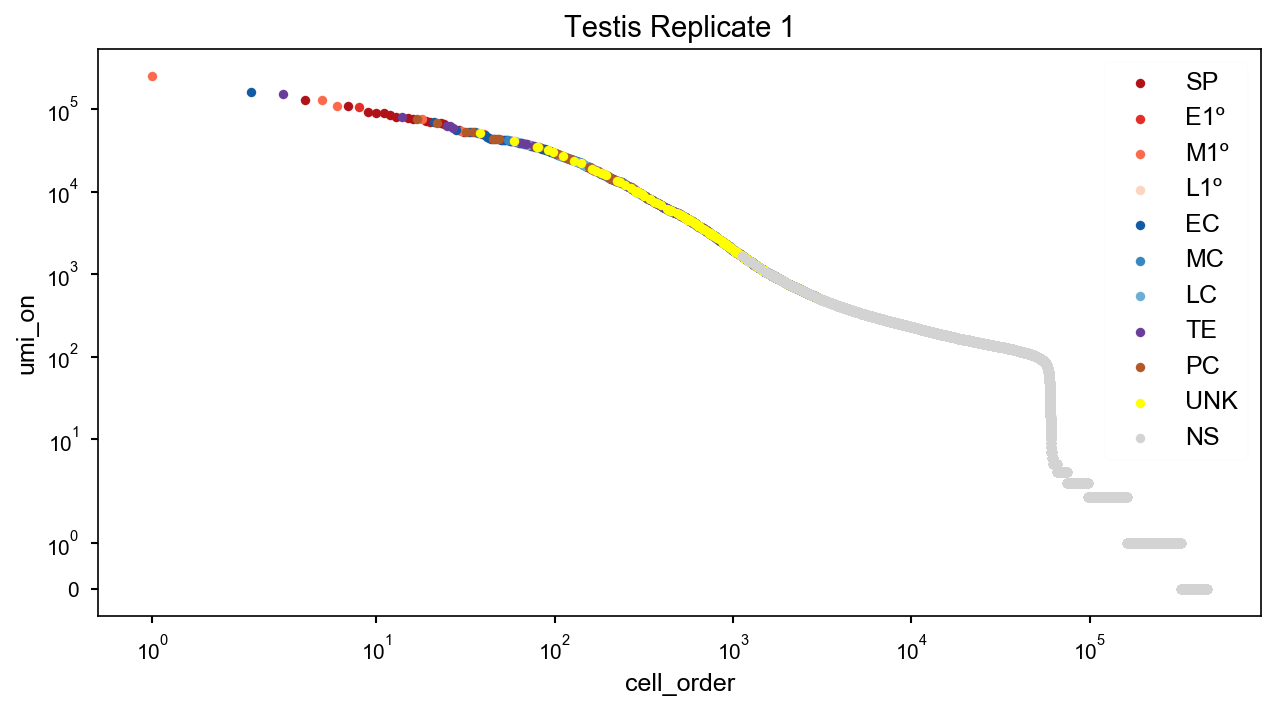

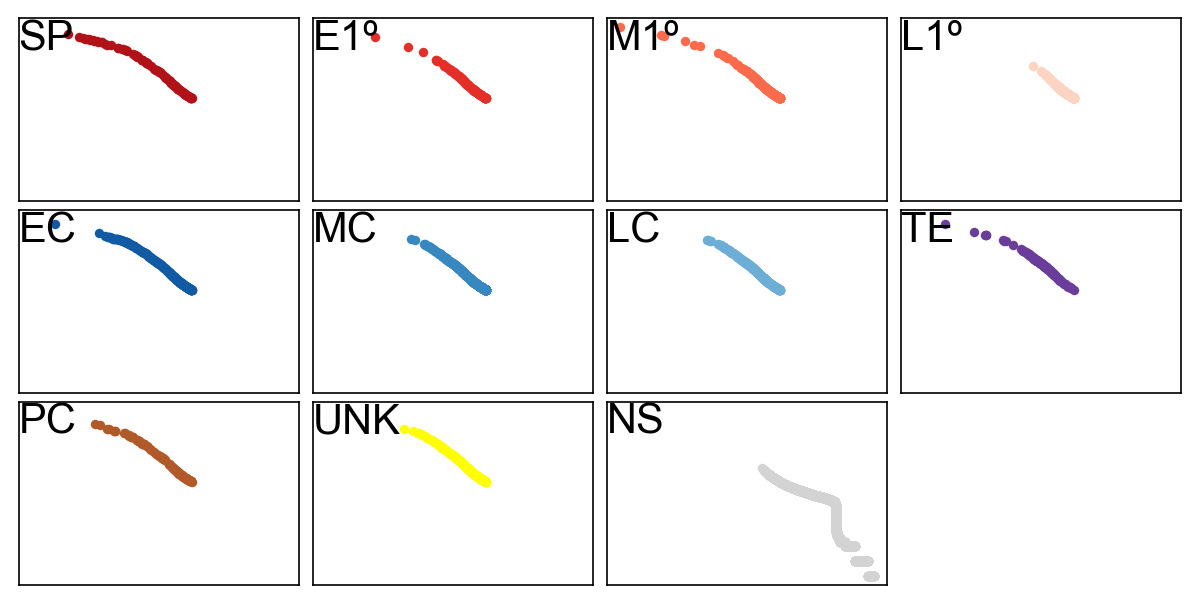

In [129]:
_plot(1)

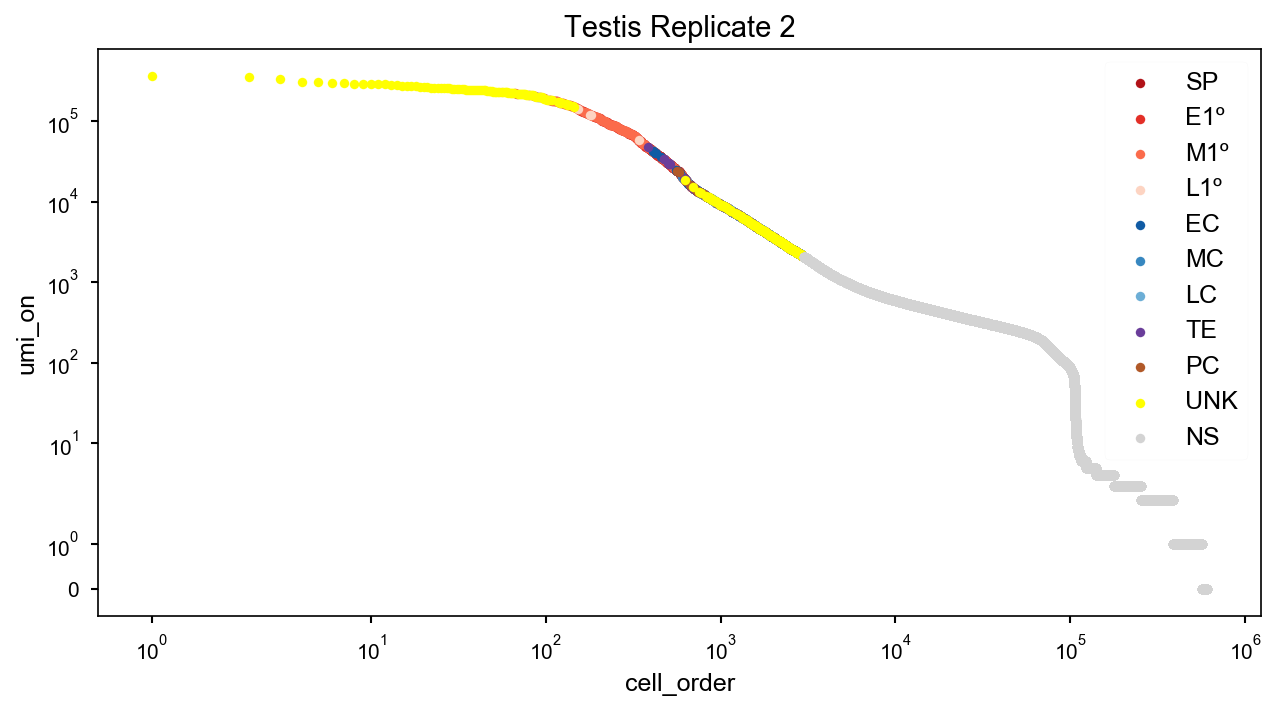

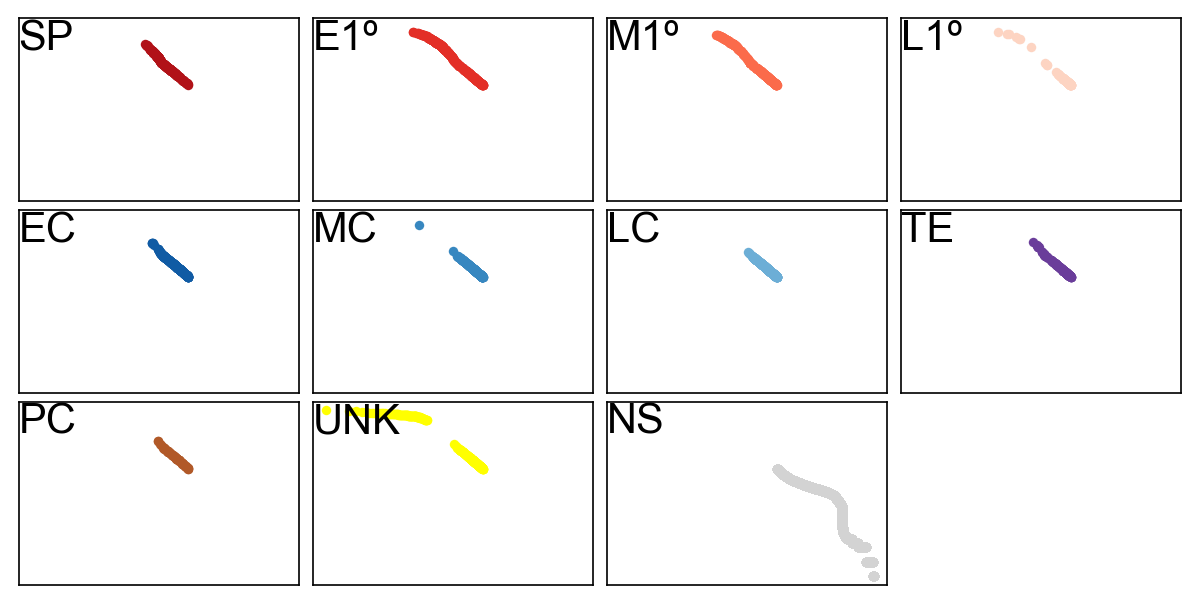

In [130]:
_plot(2)

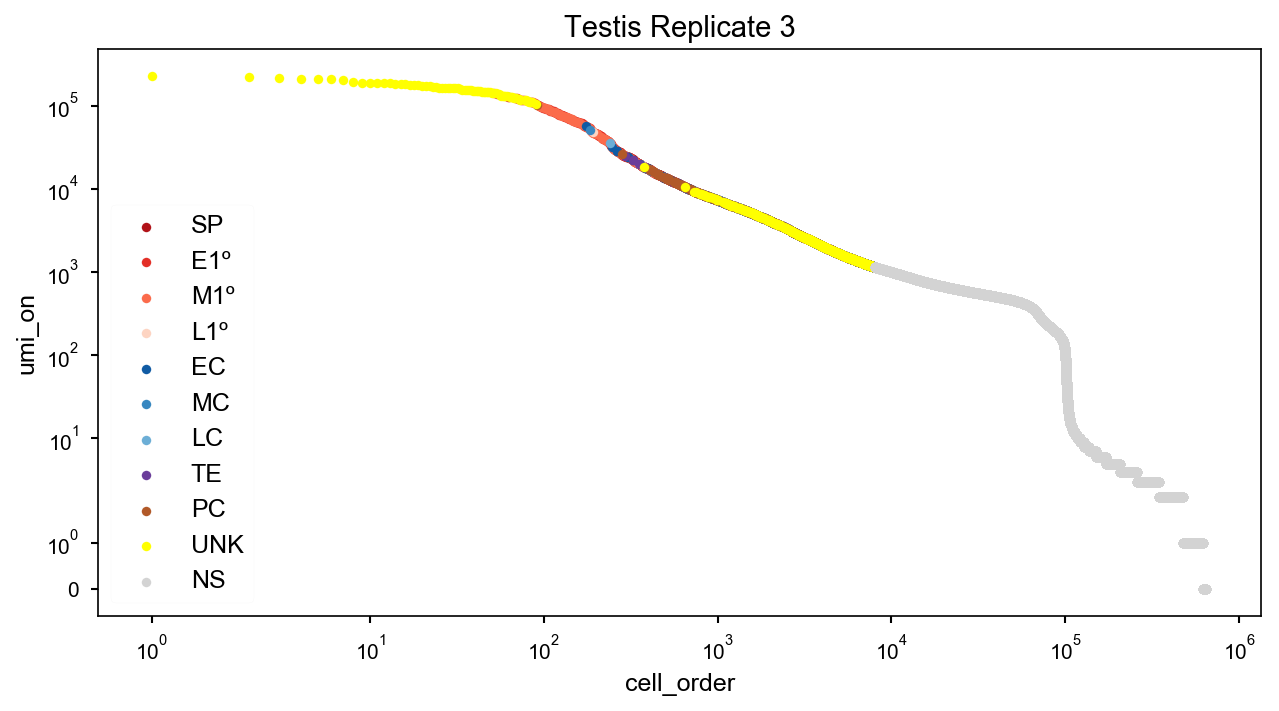

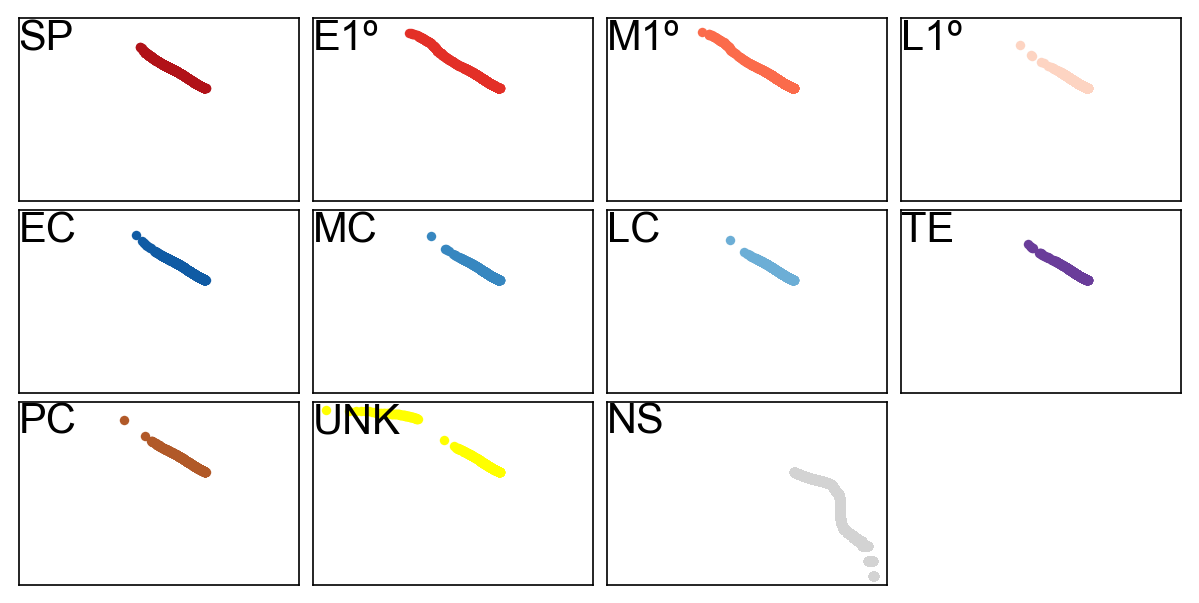

In [131]:
_plot(3)

In [136]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw.parquet')

In [177]:
gene_cnts = (
    pd.concat([(raw > 0).sum().rename('num_genes_on'), clusters], axis=1)
    .assign(rep=lambda df: df.index.str.extract('(rep\d)', expand=False))
)
gene_cnts.cluster = gene_cnts.cluster.cat.remove_unused_categories()

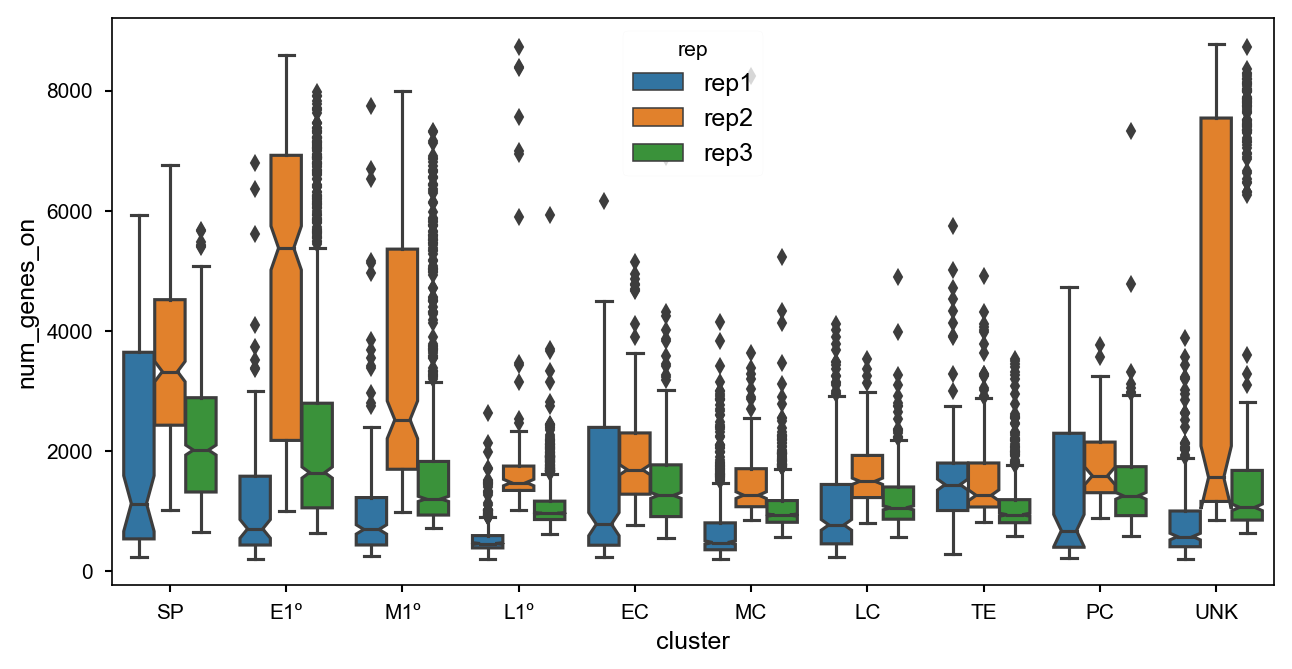

In [184]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot('cluster', 'num_genes_on', data=gene_cnts, hue='rep', notch=True)